In [3]:
import numpy as np
import sys
import gym
from gym import error, spaces
from gym import utils
from gym.utils import seeding
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from simulator.utils import Cube2D, Transform2D

In [34]:
class Gaussian(gym.Space):
    """
    A Gaussian space randomizes an action as a datapoint
    using a location and a covariance.
    
    This is actually a multivariate normal distribution (MVN),
    but with non-correlated variables 
    (the covariance matrix is diagonal and positive)
    
    A sample usage:
    self.action_space = Gaussian(location = [-1,2], diagonal_cov = [1,1])
    """
    def __init__(self, location, diagonal_cov, n_objects = 2, shape=None):
        """
        Two kinds of valid inputs
        
        - location and diagonal_cov are scalar -> Gaussian distribution
        - location and diagonal_cov are np array of same size
        """
        self.n_objects = n_objects
        
        if np.isscalar(location) and np.isscalar(diagonal_cov):
            """Gaussian distribution"""
            self.location = np.array([location])
            self.diagonal_cov = np.array([diagonal_cov])
            self.shape = (1,)
        elif isinstance(location, list) and isinstance(diagonal_cov, list):
            assert len(location) == len(diagonal_cov)
            
            self.location = np.array(location)
            self.diagonal_cov = np.diag(diagonal_cov)
            
            self.shape = self.location.shape
        else:
            assert isinstance(location, np.ndarray)
            assert isinstance(diagonal_cov, np.ndarray)
            assert location.shape == diagonal_cov.shape
        
            self.shape = location.shape
            
            self.location = np.flatten(location)
            self.diagonal_cov = np.diag(np.flatten(diagonal_cov))
            
    def sample(self, object_index = None):
        """
        sample an action to take:
        
        if object_index == None:
            sample both object_index and location of final point
        else:
            sample jus the location of final point
        """
        s = np.random.multivariate_normal(self.location, self.diagonal_cov)
        
        # Reshape to original 
        s.shape = self.shape
        
        if object_index:
            return (object_index, s)
        else:
            object_index = np.random.choice(self.n_objects)
            return (object_index, s)
            
    def __repr__(self):
        return "MVN (location= " + str(self.location) + "; variances = " + str(self.diagonal_cov) +")"
    
    def __eq__(self, other):
        return np.allclose(self.location, other.location) and \
                np.allclose(self.diagonal_cov, other.diagonal_cov)

In [55]:
class Uniform(gym.Space):
    """
    A uniform distributioin in a bounded 
    N-dimensional cube
    
    A sample usage:
    Create a square (-1,-1), (-1,1), (1,1), (1,-1)
    self.state_space = Uniform(p = [-1,-1], dimension = [2,2])
    """
    def __init__(self, p, dimension, randomizer = np.random):
        self.p = np.array(p)
        self.dimension = np.array(dimension)
        self.p_opposite = self.p + self.dimension
        self.randomizer = randomizer
        
    def sample(self):
        return self.randomizer.uniform(self.p, self.p_opposite)
    
    def __repr__(self):
        return "Uniform (p= " + str(self.p) + "; dimension = " + str(self.dimension) +")"
    
    def __eq__(self, other):
        return np.allclose(self.p, other.p) and \
                np.allclose(self.dimension, other.dimension)

In [46]:
def make_lines(shape):
    lines = []
    for i in range(len(shape)):
        j = (i + 1) % len(shape)
        lines.append( [ shape[i], shape[j] ] )
    
    return lines

In [69]:
from matplotlib import pyplot as plt
import pylab as pl
from matplotlib import collections as mc

In [157]:
colors = [ (1, 0, 0, 1), (0,1,0,1), (0,0,1,1), 
          (0.5, 0.5, 0, 1), (0,0.5, 0.5,1), (0.5, 0, 0.5,1),
         (0.7, 0.3, 0, 1), (0,0.7, 0.3,1), (0.7, 0, 0.3,1),
         (0.3, 0.7, 0, 1), (0,0.3, 0.7,1), (0.3, 0, 0.7,1)]

In [107]:
from simulator.simulator2d import Environment

In [163]:
class BlockMovementEnv(gym.Env):
    reward_range = (0, 1)
    metadata = {'render.modes': ['human']}
    """
    """
    def __init__(self, target, playground_x = [-1,-1, 0],
                 playground_dim = [2, 2, np.pi/2], name=None, n_objects = 2,
                block_size = 0.15, 
                 progress_threshold = 0.9):
        """
        Parameters:
        - name: the name of the event action to be learned
        - target: is a function that produces
        a value between 0 and 1 (event progress function)
        - playground: a rectangle (x, y, rot, width, height, rot_range)
        where (x,y) is a corner of the rectangle
        - block_size: the default size for a block
        - n_objects: number of objects to be randomized
        - progress_threshold: condition for an episode to end
        
        **Note**
        target_function:
        event progress function will be defined based on the event type 
        currently learned
        
        target_function would be an LSTM
        
        
        """
        # This env is just a wrapper around an environment that 
        # I have created before
        self.e = Environment()
        self.target = target
        self.n_objects = n_objects
        self.playground_x = playground_x
        self.playground_dim = playground_dim
        self.name = name
        self.block_size = block_size
        
        # Action space is dynamically created
        # The action space would be a combination of a 
        self.action_space = None
        # observation space is a subset of multiple object spaces
        self.observation_space = None 
        
        self._seed()
        
        self.object_space = Uniform(p = playground_x, 
                                         dimension = playground_dim, 
                                         randomizer = self.np_random)
        
        
        self._reset()
        
    def _step(self, action):
        # action is generated from the action_policy (external to the environment)
        object_index, new_location = action
        
        position = new_location[:2]
        rotation = new_location[2]
        scale = self.s[object_index].transform.scale
        
        self.s[object_index] = Cube2D(transform = Transform2D(position, rotation, scale))
        self.lastaction = action
        
        
        current_progress = self.target.predict()
        
        return (self.s)
    
    def _reset(self):
        # states would be a list of location/orientation for block
        # sampled from the observation space
        for i in range(self.n_objects):
            # Retry randomize a few times
            retry = 0
            
            while True:
                obj_params = self.object_space.sample()

                position = obj_params[:2]
                rotation = obj_params[2]
                scale = self.block_size / 2

                o = Cube2D(transform = Transform2D(position, rotation, scale))

                if self.e.add_object(o):
                    break
                    
                if retry > 3:
                    break
                
                retry += 1
            
        self.lastaction=None
        self.s = self.e.objects
        return self.s

    def _render(self, mode='human', close=False):
        if close:
            return
        
        fig, ax = plt.subplots()
        ax.set_xticks(np.arange(self.playground_x[0], 
                                self.playground_x[0] + self.playground_dim[0], 0.1))
        ax.set_yticks(np.arange(self.playground_x[1], 
                                self.playground_x[1] + self.playground_dim[1], 0.1))
        ax.set_xlim([self.playground_x[0], 
                     self.playground_x[0] + self.playground_dim[0]])
        ax.set_ylim([self.playground_x[1], 
                     self.playground_x[1] + self.playground_dim[1]])
        fig.set_size_inches(20, 12)
        
        for i in range(self.n_objects):
            # Obj is action position and rotation of object
            obj = self.s[i]
            
            shape = obj.get_markers()
            
            lines = make_lines(shape)
            lc = mc.LineCollection(lines, colors=colors[i], linewidths=2)
            ax.add_collection(lc)
        
        ax.autoscale()
        ax.margins(0.1)

        plt.show()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [164]:
env = BlockMovementEnv(None)

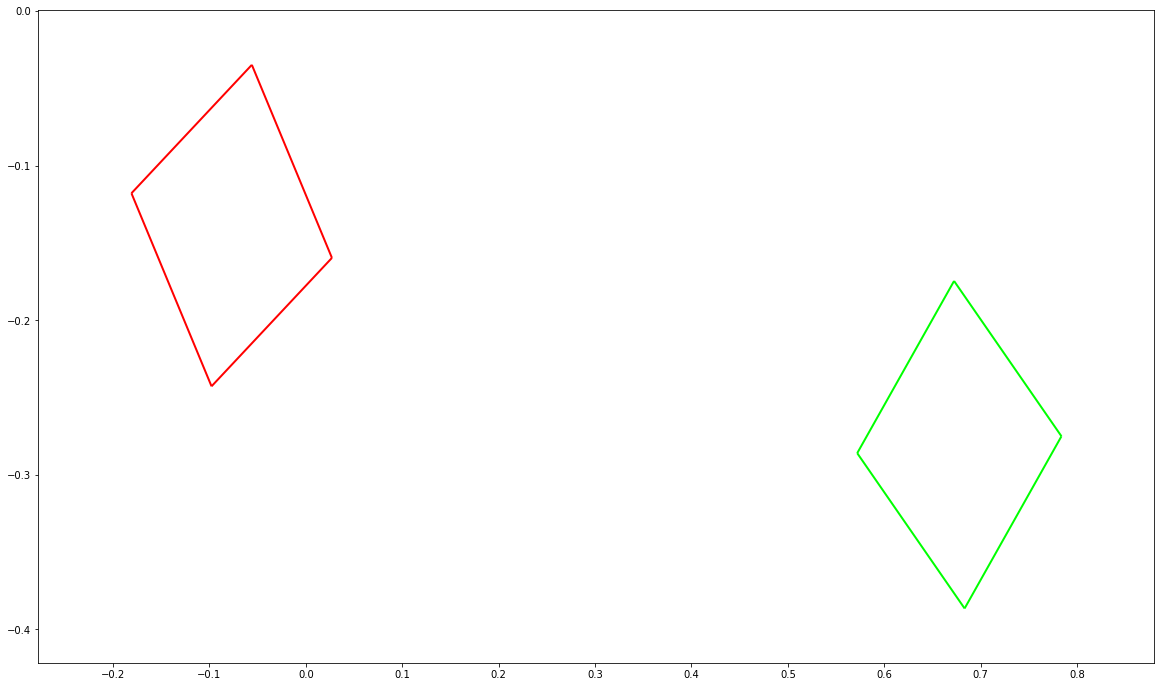

In [166]:
env.reset()
env.render()

In [120]:
class ProgressConfig(object):
    s2s = False

class EventProgressEstimator(object):
    """
    Estimate the progress of event using LSTM
    """
    def __init__(self, is_training, name=None, config = ProgressConfig()):
        self.num_steps = num_steps = config.num_steps
        self.n_input = n_input = config.n_input
        self.size = size = config.hidden_size
        # This is an option, if self.s2s = True -> Use all progress values
        # otherwise just use the last progress value
        self.s2s = config.s2s 
        
        with tf.variable_scope(name):
            "Declare all placeholders"
            "Placeholder for input"
            
            """
            batch_size
            num_steps: length of sequence
            n_input: size of feature vectors
            """
            self._input_data = tf.placeholder(tf.float32, [None, num_steps, n_input])
            
            """
            (batch_size x num_steps) for sequence to sequence
            batch_size for 
            """
            if self.s2s:
                self._targets = tf.placeholder(tf.float32, [None, num_steps])
            else:
                self._targets = tf.placeholder(tf.float32, [None])
            
            lstm_cell = BasicLSTMCell(size, forget_bias = 1.0, state_is_tuple=True)
            
            if is_training and config.keep_prob < 1:
                lstm_cell = DropoutWrapper(lstm_cell, output_keep_prob=config.keep_prob)
                
            multi_lstm_cell = MultiRNNCell([lstm_cell] * config.num_layers, state_is_tuple=True)
            
            # Initial states of the cells
            # cell.state_size = config.num_layers * 2 * size
            # Size = ( batch_size x cell.state_size )
            
            # We don't know the batch_size here, so don't need
            # to specify initial_state
            # self._initial_state = multi_lstm_cell.zero_state(batch_size, tf.float32)
            
            inputs = tf.reshape(self._input_data, [-1, n_input]) # (batch_size * num_steps, n_input)
            
            with tf.variable_scope("linear"):
                weight = tf.get_variable("weight", [n_input, size])
                bias = tf.get_variable("bias", [size])

                # (batch_size * num_steps, size)
                inputs = tf.matmul(inputs, weight) + bias
                
            inputs = tf.reshape(inputs, (-1, num_steps, size)) # (batch_size, num_steps, size)
            
            # (output, state)
            # output is of size:  ( batch_size, num_steps, size ) or (( batch_size, size ))
            # state is of size:   ( batch_size, cell.state_size ) (last state only)
            with tf.variable_scope("lstm"):
                output_and_state = tf.nn.dynamic_rnn(multi_lstm_cell, inputs, dtype=tf.float32)
            
            output = output_and_state[0]
            # we will pass the hidden state to next run of lstm
            self._final_state = output_and_state[1]
            
            with tf.variable_scope("output_linear"):
                weight = tf.get_variable("weight", [size, 1])
                bias = tf.get_variable("bias", [1])

                
                if self.s2s:
                    # Need to reshape to 2 dimensions
                    output = tf.reshape(output, [-1, size])
                    output = output @ weight + bias
                    # ( batch_size, num_steps )  
                    output = tf.reshape(output, [-1, num_steps])
                else:
                    #( batch_size, 1)
                    # @ is the same as matmul
                    output = output @ weight + bias
                    
            # Remove all 1 dimension
            # ( batch_size, num_steps ) or (batch_size)
            self.output = tf.squeeze(output)
            
            # Loss = mean squared error of target and predictions
            self.loss = tf.losses.mean_squared_error(self._targets, output)
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def checkInputs(self, inputs):
        assert isinstance(inputs, np.ndarray)
        
        assert len(inputs.shape) == 3
        assert inputs.shape[1] == self.num_steps
        assert inputs.shape[2] == self.n_input
    
    def checkOutputs(self, outputs, batch_size):
        assert isinstance(outputs, np.ndarray)
        if self.s2s:
            assert len(outputs.shape) == 2
            assert outputs[0] == batch_size
            assert outputs[1] == self.num_steps
        else:
            assert len(outputs.shape) == 1
            assert outputs[0] == batch_size
            
        
    def update(self, inputs, outputs, sess=None):
        """
        inputs: np.array (batch_size, num_steps, n_input)
        outputs: np.array (batch_size, num_steps) or (batch_size)
        
        We need to run train_op to update the parameters
        We also need to return its loss
        """
        self.checkInputs(inputs)
        
        batch_size = inputs.shape[0]
        
        self.checkOutputs(outputs, batch_size)
        
        sess = sess or tf.get_default_session()
        _, loss = sess.run([self.train_op, self.loss], 
                           {self._input_data: inputs, self._targets: outputs})
        
        return loss
    
    def predict(self, inputs, outputs = None, sess=None):
        """
        inputs: np.array (batch_size, num_steps, n_input)
        outputs: np.array (batch_size, num_steps) or (batch_size)
        
        This function would not run train_op
        outputs is only optional if we want to get the loss
        """
        self.checkInputs(inputs)
        
        if outputs != None:
            batch_size = inputs.shape[0]
            self.checkOutputs(outputs, batch_size)
        
        sess = sess or tf.get_default_session()
        
        if outputs != None:
            predicted, loss = sess.run([self.output, self.loss],
                    {self._input_data: inputs, self._targets: outputs})
            return (predicted, loss)
        else:
            predicted = sess.run(self.output,
                    {self._input_data: inputs})
            return predicted

In [151]:
from utils import DATA_DIR, FIRST_EXPERIMENT_CLASSES,\
    SESSION_NAME, SESSION_OBJECTS, SESSION_EVENTS, GLYPH_BOX, NORMAL, \
    START, END, LABEL
from read_utils import load_one_param_file
from feature_util import project_to2d, qsr_feature_extractor

In [181]:
# Copy from feature_util because I couldn't load it

def interpolate_multi_object_data( session_len, object_data, object_names = [] ):
    """
    
    """
    data = {}
    for object_name in object_names:
        data[object_name] = _interpolate_object_data( session_len, object_data[object_name])
    return data


def _interpolate_object_data( session_len, one_object_data ):
    '''
    Interpolate data for missing frames

    ===========
    Params: 
    object_data: chain of features, one feature vector for each frame (interpolated frames) for one object
    '''
    new_one_object_data = []
    sorted_keys = sorted(one_object_data.keys())
    for frame in range(session_len):
        if frame not in one_object_data:
            # missing frame
            frame_position = bisect.bisect_left(sorted_keys, frame)

            if frame_position == 0:
                # missing at the beginning
                new_one_object_data.append(one_object_data[sorted_keys[0]])
            elif frame_position == len(sorted_keys):
                # missing at the end
                new_one_object_data.append(one_object_data[sorted_keys[-1]])
            else:
                pre_key = sorted_keys[frame_position - 1]
                nex_key = sorted_keys[frame_position]
                pre = one_object_data[pre_key].transform
                nex = one_object_data[nex_key].transform
                
                p = (frame - pre_key)/(nex_key - pre_key)
                q = (nex_key - frame)/(nex_key - pre_key)
                transfrom = Transform2D ( nex.position * p + pre.position * q , 
                                         nex.rotation * p + pre.rotation * q, 
                                         nex.scale * p + pre.scale * q)
                new_one_object_data[frame].append(Cube2D( transfrom ))
        else:
            new_one_object_data[frame].append(one_object_data[frame])
    return new_one_object_data

In [124]:
session_1 = load_one_param_file(os.path.join( DATA_DIR, 'SlideAround', 'Session1', 'files.param'))
session_2 = load_one_param_file(os.path.join( DATA_DIR, 'SlideAround', 'Session2', 'files.param'))

'NoneType' object has no attribute 'findall'
'NoneType' object has no attribute 'findall'


In [178]:
sessions = [session_1, session_2]

In [184]:
print (session_1.keys())
print (session_1['session_events'])

print (session_2.keys())
print (session_2['session_events'])

dict_keys(['session_events', 'session_name', 'session_objects', 'session_length'])
[{'start': 4, 'label': ['Stella Artois', 'Shell'], 'end': 168}, {'start': 221, 'label': ['Stella Artois', 'Shell'], 'end': 335}, {'start': 414, 'label': ['Stella Artois', 'Shell'], 'end': 599}, {'start': 682, 'label': ['Stella Artois', 'Shell'], 'end': 780}, {'start': 835, 'label': ['Stella Artois', 'Shell'], 'end': 945}, {'start': 986, 'label': ['Stella Artois', 'Shell'], 'end': 1070}, {'start': 1122, 'label': ['Stella Artois', 'Shell'], 'end': 1216}, {'start': 1273, 'label': ['Stella Artois', 'Shell'], 'end': 1390}, {'start': 1443, 'label': ['Stella Artois', 'Shell'], 'end': 1541}, {'start': 1598, 'label': ['Stella Artois', 'Shell'], 'end': 1704}, {'start': 1761, 'label': ['Stella Artois', 'Shell'], 'end': 1838}, {'start': 1907, 'label': ['Stella Artois', 'Shell'], 'end': 1983}, {'start': 2024, 'label': ['Stella Artois', 'Shell'], 'end': 2091}, {'start': 2139, 'label': ['Stella Artois', 'Shell'], 'end'

In [180]:
features = []

for session in sessions:
    feature = qsr_feature_extractor(qsrlib, interpolate_multi_object_data(session['session_length'], project_to2d(session)), 'Stella Artois', 'Shell', session['session_length'])
    features.append(feature)

============ table
============ Stella Artois


D:\git\learn-to-perform\feature_util.py:34: RuntimeWarning: invalid value encountered in float_scalars
  return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
D:\git\learn-to-perform\feature\project_table.py:112: RuntimeWarning: invalid value encountered in true_divide
  
C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\numpy\linalg\linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


============ Shell


NameError: name 'session_data' is not defined

In [167]:
env2 = BlockMovementEnv(None, n_objects = 10)


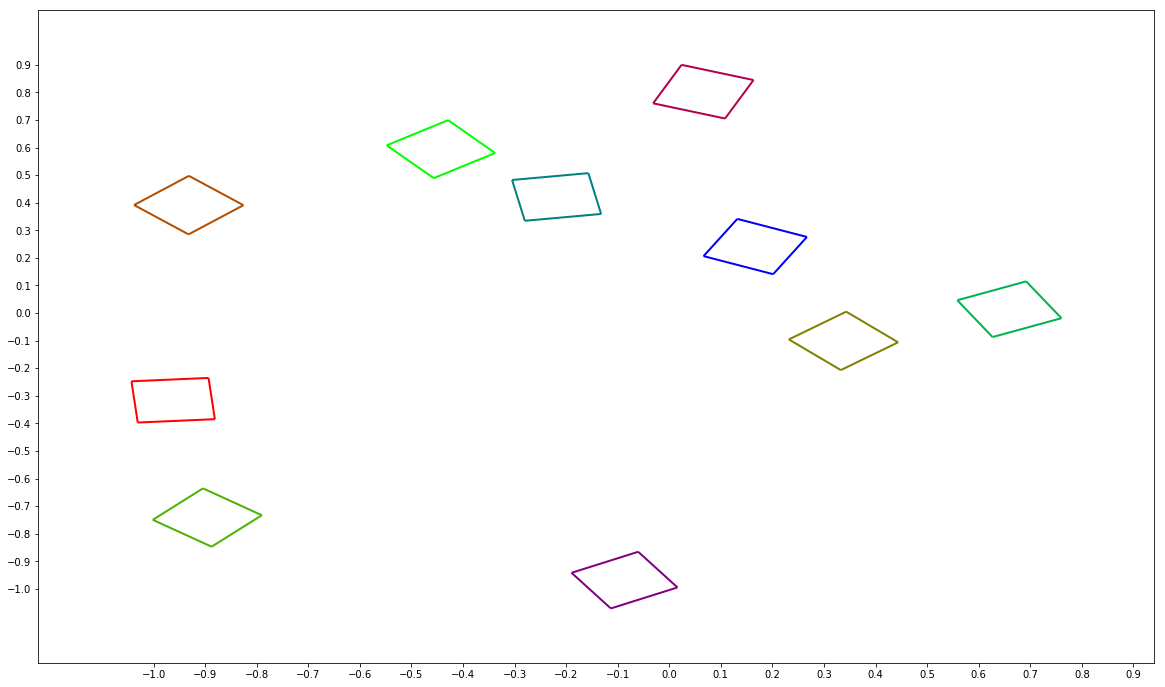

In [170]:
env2.reset()
env2.render()

In [196]:
"""
Downstream running framework


"""

2

In [205]:
[0,3] + list(range(4))

[0, 3, 0, 1, 2, 3]

In [209]:
list(np.arange(0.0,1.0,0.25))

[0.0, 0.25, 0.5, 0.75]

A test bed for downstream processing